In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from scipy import integrate
from numba import njit
import scipy.stats

# Distribucion exponencial

In [66]:
tau=60.55/np.log(2)
gamma=1/tau
print(f"gamma = {gamma}")


gamma = 0.011447517432864497


In [67]:
t=np.arange(0,20*tau+1,5)
tmed=((t+np.roll(t, shift=1))/2)[1:]

def P(t):
    return gamma*np.exp(-gamma*t)

pdf=np.array([integrate.quad(P,i,i+5)[0] for i in t[:-1]]) #integramos en el dt para obtener la pdf en el tiempo

cdf=np.cumsum(pdf) 
cdf=np.insert(cdf, 0, 0)#encontramos la cdf

In [68]:
rn.seed(6320)
#Función para simular decaimientos de N núcleos
@njit
def simul(N):
    histograma=np.zeros(N)
    for i in range(N):
        r = rn.random()
        if r <= cdf.max():
            for j in np.arange(1,len(cdf)):
                if r >= cdf[j-1] and r < cdf[j]:             
                    histograma[i]=tmed[j-1]
                    break
        else:
            continue
    no_cero = np.nonzero(histograma)
    histograma=histograma[no_cero] #los valores que quedan 0 son para aquellos nucleos que decaen después de 4 tau
    return histograma       #retorna lista con el minuto en que decayó cada núcleo

N=np.array([1e2,1e3,1e6,1e8])
s1=[]
j=0
for n in N:
    x=simul(int(n))   #simulamos para las diferentes cantidades de núcleos
    dec=np.histogram(x,t)[0]
    dec=np.append(dec,0)
    s1.append(dec)  


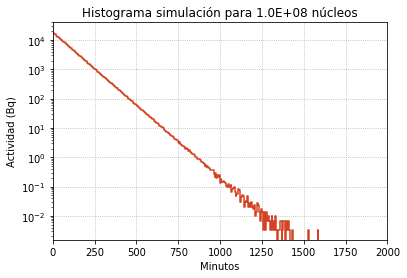

In [69]:
fig,ax=plt.subplots()
ax.plot(t,s1[3]/(60*5),label=("Simulación"),ds="steps-mid",color="#D54123")
ax.set_title(f"Histograma simulación para {N[3]:.1E} núcleos")
ax.set_ylabel("Actividad (Bq)")
ax.set_xlabel("Minutos")
ax.set_yscale("log")
ax.grid(linestyle=':')
ax.set_xlim(0,2000)
plt.show()


# Simulacion Binomial

In [70]:
@njit
def simul2(N):
    numero_nucleos=N
    numero_decaimientos=[]
    tiempos=[]
    ti=0
    while numero_nucleos > 0:
        dec=0
        for n in range(0,numero_nucleos):
            r=rn.random()
            if r < pdf[0]:
                dec+=1    
        tiempos.append(ti)
        numero_decaimientos.append(dec)
        ti+=5
        numero_nucleos-=dec
        
    return np.array([tiempos,numero_decaimientos])

N=np.array([1e2,1e3,1e6,1e8])
s2=[]
for n in N:
    s2.append(simul2(int(n)))   #simulamos para las diferentes cantidades de núcleos

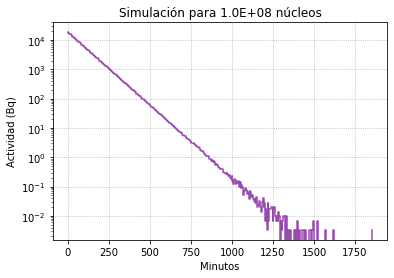

In [71]:
fig , ax = plt.subplots()  #Graficacion



ax.plot(s2[3][0],s2[3][1]/(60*5),color="#984AB0",label=("Simulación binomial"),alpha=1,ds="steps-mid") 
ax.set_title(f"Simulación para {N[3]:.1E} núcleos")
ax.set_ylabel("Actividad (Bq)")
ax.set_xlabel("Minutos")
ax.set_yscale("log")
ax.grid(linestyle=':')
 

# Simulacion Poissson

In [72]:

def simul3(N):
    numero_nucleos=N
    numero_decaimientos=[]
    tiempos=[]
    ti=0
    while numero_nucleos > 0:
        dec=poisson.rvs(pdf[0]*numero_nucleos,size=1)[0]
        tiempos.append(ti)
        numero_decaimientos.append(dec)
        ti+=5
        numero_nucleos-=dec
        
    return np.array([tiempos,numero_decaimientos])

N=np.array([1e2,1e3,1e6,1e8])
s3=[]
for n in N:
    s3.append(simul3(int(n)))   #simulamos para las diferentes cantidades de núcleos

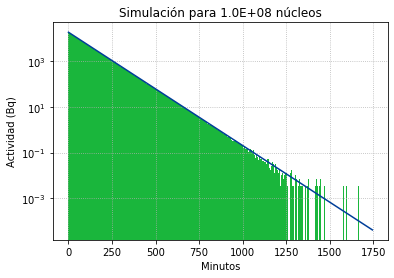

In [73]:
fig , ax = plt.subplots()  #Graficacion

ax.bar(s3[3][0],s3[3][1]/(5*60),color="#1AB63C",label=("Simulación binomial"),width=5) 
ax.plot(t,N[3]*P(t)/60,color="#003E99")
ax.set_title(f"Simulación para {N[3]:.1E} núcleos")
ax.set_ylabel("Actividad (Bq)")
ax.set_xlabel("Minutos")
ax.set_yscale("log")
ax.grid(linestyle=':')

### T4 Probabilidad de que x nucleos decaigan en un intervalo de tiempo
Empleando la funcion anterior, se puede graficar para el tiempo deseado la probabilidad de que x nucleos decaigan.

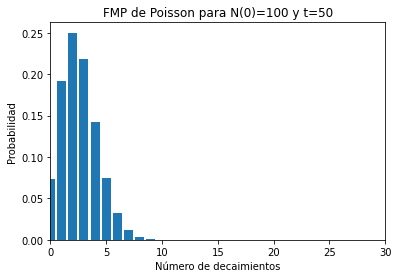

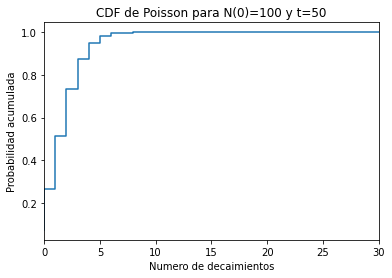

In [74]:
def simul3_t(N, time):
    numero_nucleos = N
    numero_decaimientos = []
    tiempos = []
    ti = 0
    x_nucleos = []
    poissonPMF = []
    poissonCDF = []

    while numero_nucleos > 0:
        dec = poisson.rvs(pdf[0] * numero_nucleos, size=1)[0]
        tiempos.append(ti)
        numero_decaimientos.append(dec)
        numero_nucleos -= dec

        if time >= ti and time < (ti + 5):  # Calcular PMF y CDF de Poisson para el tiempo deseado
            x_nucleos = range(0, numero_nucleos + 1)
            poissonCDF = poisson.cdf(x_nucleos, pdf[0] * numero_nucleos)
            poissonPMF = poisson.pmf(x_nucleos, pdf[0] * numero_nucleos)

        ti += 5

    return tiempos, numero_decaimientos, x_nucleos, poissonPMF, poissonCDF

time = 50 #tiempo en el cual se desea graficar PMF y CDF
s = simul3_t(100, time)

plt.bar(s[2], s[3])
plt.xlabel("Número de decaimientos")
plt.ylabel("Probabilidad")
plt.title("FMP de Poisson para N(0)=100 y t="+str(time))
plt.xlim(0, 30)
#plt.savefig('T4'+str(time)+'PMF.png', dpi=300)
plt.show()

plt.step(s[2], s[4])
plt.xlabel("Numero de decaimientos")
plt.ylabel("Probabilidad acumulada")
plt.title("CDF de Poisson para N(0)=100 y t="+str(time))
plt.xlim(0, 30)
#plt.savefig('T4'+str(time)+'CDF.png', dpi=300)
plt.show()


### Graficación T5,T6 y T7 

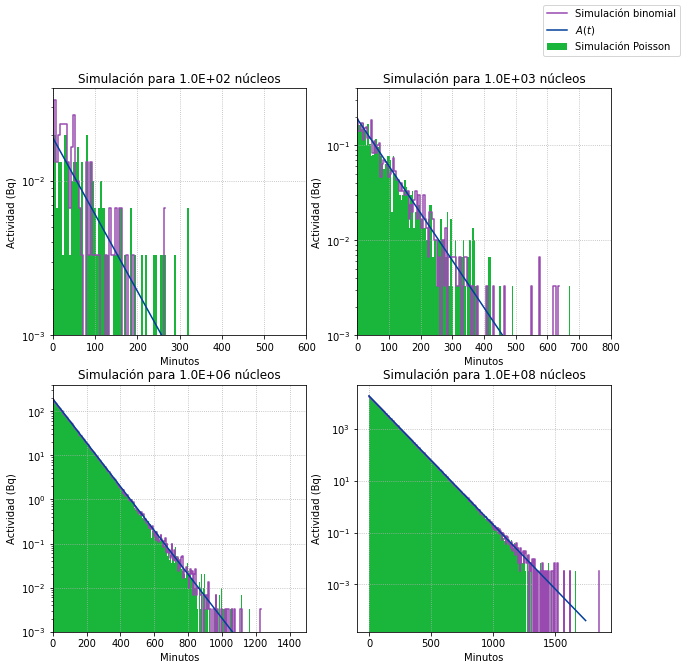

In [75]:
fig , ax = plt.subplots(2,2,figsize=(10,10))  #Graficacion

ax[0,0].plot(s2[0][0],s2[0][1]/(60*5),color="#984AB0",alpha=1,ds="steps-mid",label=("Simulación binomial")) 
ax[0,0].bar(s3[0][0],s3[0][1]/(5*60),color="#1AB63C",label=("Simulación Poisson"),width=5) 
ax[0,0].plot(t,N[0]*P(t)/60,color="#003E99",label=r"$A(t)$") #Se multiplica por N la pdf para comparar con el histograma
ax[0,0].set_title(f"Simulación para {N[0]:.1E} núcleos")
ax[0,0].set_ylabel("Actividad (Bq)")
ax[0,0].set_xlabel("Minutos")
ax[0,0].set_yscale("log")
ax[0,0].grid(linestyle=':')
ax[0,0].set_xlim(0,600)
ax[0,0].set_ylim(1e-3,4e-2)

ax[0,1].plot(s2[1][0],s2[1][1]/(60*5),color="#984AB0",alpha=1,ds="steps-mid") 
ax[0,1].bar(s3[1][0],s3[1][1]/(5*60),color="#1AB63C",width=5) 
ax[0,1].plot(t,N[1]*P(t)/60,color="#003E99")
ax[0,1].set_title(f"Simulación para {N[1]:.1E} núcleos")
ax[0,1].set_ylabel("Actividad (Bq)")
ax[0,1].set_xlabel("Minutos")
ax[0,1].set_yscale("log")
ax[0,1].grid(linestyle=':')
ax[0,1].set_xlim(0,800)
ax[0,1].set_ylim(1e-3,4e-1)

ax[1,0].plot(s2[2][0],s2[2][1]/(60*5),color="#984AB0",alpha=1,ds="steps-mid") 
ax[1,0].bar(s3[2][0],s3[2][1]/(5*60),color="#1AB63C",width=5) 
ax[1,0].plot(t,N[2]*P(t)/60,color="#003E99")
ax[1,0].set_title(f"Simulación para {N[2]:.1E} núcleos")
ax[1,0].set_ylabel("Actividad (Bq)")
ax[1,0].set_xlabel("Minutos")
ax[1,0].set_yscale("log")
ax[1,0].grid(linestyle=':')
ax[1,0].set_xlim(0,1500)
ax[1,0].set_ylim(1e-3,4e2)

ax[1,1].plot(s2[3][0],s2[3][1]/(60*5),color="#984AB0",alpha=1,ds="steps-mid") 
ax[1,1].bar(s3[3][0],s3[3][1]/(5*60),color="#1AB63C",width=5) 
ax[1,1].plot(t,N[3]*P(t)/60,color="#003E99")
ax[1,1].set_title(f"Simulación para {N[3]:.1E} núcleos")
ax[1,1].set_ylabel("Actividad (Bq)")
ax[1,1].set_xlabel("Minutos")
ax[1,1].set_yscale("log")
ax[1,1].grid(linestyle=':')


fig.legend()
plt.show()


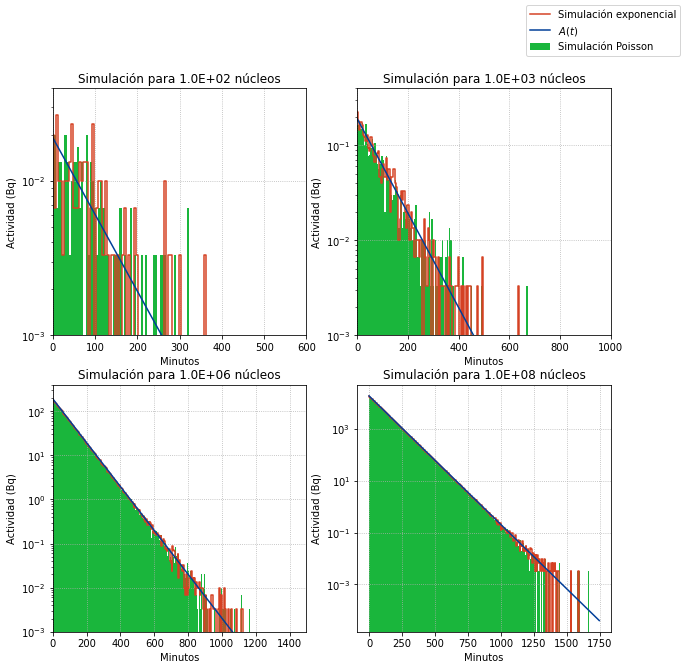

In [76]:
fig , ax = plt.subplots(2,2,figsize=(10,10))  #Graficacion

ax[0,0].plot(t,s1[0]/(60*5),ds="steps-mid",color="#D54123",label=("Simulación exponencial"))
ax[0,0].bar(s3[0][0],s3[0][1]/(5*60),color="#1AB63C",label=("Simulación Poisson"),width=5) 
ax[0,0].plot(t,N[0]*P(t)/60,color="#003E99",label=r"$A(t)$") #Se multiplica por N la pdf para comparar con el histograma
ax[0,0].set_title(f"Simulación para {N[0]:.1E} núcleos")
ax[0,0].set_ylabel("Actividad (Bq)")
ax[0,0].set_xlabel("Minutos")
ax[0,0].set_yscale("log")
ax[0,0].grid(linestyle=':')
ax[0,0].set_xlim(0,600)
ax[0,0].set_ylim(1e-3,4e-2)

ax[0,1].plot(t,s1[1]/(60*5),ds="steps-mid",color="#D54123")
ax[0,1].bar(s3[1][0],s3[1][1]/(5*60),color="#1AB63C",width=5) 
ax[0,1].plot(t,N[1]*P(t)/60,color="#003E99")
ax[0,1].set_title(f"Simulación para {N[1]:.1E} núcleos")
ax[0,1].set_ylabel("Actividad (Bq)")
ax[0,1].set_xlabel("Minutos")
ax[0,1].set_yscale("log")
ax[0,1].grid(linestyle=':')
ax[0,1].set_xlim(0,1000)
ax[0,1].set_ylim(1e-3,4e-1)

ax[1,0].plot(t,s1[2]/(60*5),ds="steps-mid",color="#D54123")
ax[1,0].bar(s3[2][0],s3[2][1]/(5*60),color="#1AB63C",width=5) 
ax[1,0].plot(t,N[2]*P(t)/60,color="#003E99")
ax[1,0].set_title(f"Simulación para {N[2]:.1E} núcleos")
ax[1,0].set_ylabel("Actividad (Bq)")
ax[1,0].set_xlabel("Minutos")
ax[1,0].set_yscale("log")
ax[1,0].grid(linestyle=':')
ax[1,0].set_xlim(0,1500)
ax[1,0].set_ylim(1e-3,4e2)

ax[1,1].plot(t,s1[3]/(60*5),ds="steps-mid",color="#D54123")
ax[1,1].bar(s3[3][0],s3[3][1]/(5*60),color="#1AB63C",width=5) 
ax[1,1].plot(t,N[3]*P(t)/60,color="#003E99")
ax[1,1].set_title(f"Simulación para {N[3]:.1E} núcleos")
ax[1,1].set_ylabel("Actividad (Bq)")
ax[1,1].set_xlabel("Minutos")
ax[1,1].set_yscale("log")
ax[1,1].grid(linestyle=':')


fig.legend()
plt.show()